In [2]:
%%time
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import re
import nltk
import json
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score
from sklearn.metrics import average_precision_score,roc_auc_score, roc_curve, precision_recall_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
np.random.seed(42)
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import ToktokTokenizer
import nltk, string, re, spacy,unicodedata, random
from bs4 import BeautifulSoup
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
CPU times: user 1.16 ms, sys: 0 ns, total: 1.16 ms
Wall time: 1.11 ms


In [3]:
train_df = pd.read_csv("/kaggle/input/abusive/AWT_train.csv")
dev_df = pd.read_csv("/kaggle/input/abusive/AWT_dev.csv")
test_df = pd.read_csv('/kaggle/input/abusive/AWT_test_with_labels.csv')

print("Total number of training samples:", len(train_df))
print("Total number of dev samples:", len(dev_df))
print("Total number of test samples:", len(test_df))

Total number of training samples: 2790
Total number of dev samples: 598
Total number of test samples: 598


In [4]:
train_df.head()

,Text,Class
0,இதல்லம் ஒரு தீர்ப்பு நாட்டாமை தீர்ப்பை மற்று,Non-Abusive
1,"யாருடா அந்த கார்த்தி, நீ எங்கடா இருக்க ?",Non-Abusive
2,இரண்டு பேரின் (புண்டையை) சாமான்களை கோணிய ஊசால்...,Abusive
3,என்ன திமிர் இந்த பொண்ணுக்கு.....மக்களே இன்னும்...,Abusive
4,ஐயோ அந்த கார்த்திக் எ காட்டுங்க பா please,Non-Abusive


In [5]:
#train_df.duplicated().sum().item()
print(dev_df.duplicated().sum().item())
print(train_df.duplicated().sum().item())
test_df.duplicated().sum().item()

0
11


0

In [6]:
train_df.drop_duplicates(inplace=True)
dev_df.drop_duplicates(inplace=True)

In [7]:
print(dev_df.duplicated().sum().item())
train_df.duplicated().sum().item()

0


0

In [8]:
# Count labels
num_labels = train_df['Class'].value_counts()
print(num_labels)

Class
Non-Abusive    1421
Abusive        1357
abusive           1
Name: count, dtype: int64


In [9]:
# Change class label from 'abusive' to 'Abusive'
train_df['Class'] = train_df['Class'].replace('abusive', 'Abusive')

In [10]:
# Count labels
num_labels = train_df['Class'].value_counts()
print(num_labels)

Class
Non-Abusive    1421
Abusive        1358
Name: count, dtype: int64


In [11]:
filtered_train = train_df[lambda x: x["Text"].str.contains("[A-Za-z0-9]")]
print(filtered_train.shape)
filtered_dev = dev_df[lambda x: x["Text"].str.contains("[A-Za-z0-9]")]
print(filtered_dev.shape)
filtered_test = test_df[lambda x: x["Text"].str.contains("[A-Za-z0-9]")]
print(filtered_test.shape)

(736, 2)
(161, 2)
(155, 3)


 **Preprocessing**

In [12]:
def text_to_word_list(text):
    text = text.split()
    return text

def replace_strings(text):
    emoj = re.compile("["         # this emoj is to remove all emojis
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           u"\u00C0-\u017F"          #latin
                           u"\u2000-\u206F"          #generalPunctuations

                           "]+", flags=re.UNICODE)
    #english_pattern=re.compile('[a-zA-Z0-9]+', flags=re.I)
    #latin_pattern=re.compile('[A-Za-z\u00C0-\u00D6\u00D8-\u00f6\u00f8-\u00ff\s]*',)

    text=emoji_pattern.sub(r'', text)
    text=emoj.sub(r'',text)
    text=text.lower()
    text=re.sub(r'\s+', ' ', text)

    text = BeautifulSoup(text, 'html.parser').get_text()
    text = re.sub(r'(https|http|www)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', ' ', text, flags=re.MULTILINE)

    text = text.replace('\n', ' ')
    text = text.replace('—', ' ')
    text = text.replace('_', ' ')
    text = text.replace('\r', ' ')
    text = re.sub(r'\\', ' ',text)
    # Stopword Removing

    #text=english_pattern.sub(r'', text)
    #def remove_emojis(text):
    #text= emoji.get_emoji_regexp().sub(r'', text)

    return text

def remove_punctuations(my_str):
    # define punctuation
    punctuations = '''````£|¢|Ñ+-*/=৳০১২৩৪৫৬৭৮৯–•।!()-[]{};:'"“\’,<>./?@#$%^&*_~‘—॥”‰🤣⚽️✌😀😃😄😁😆😅😂🤣😊😇🙂🙃😉😌😍😘😗😙😚😋😛😝😜🤪🤨🧐🤓😎🤩🥳😏😒😞😔😟😕🙁☹️😣😖😫😩😤😠😡🤬😈👿💀☠️💩🤡👹👺👻👽👾🤖💋💌💘💝💖💗💓💞💕💟❣️💔❤️‍🔥🖤🤍💯💢💥💫💦💨🕳️💣💬👁️‍🗨️🗨️🗯️💭💤👋🤚🖐️✋🖖👌✌️🤞🤟🤘🤙👈👉👆👇☝️✍️👏👏🏻👏🏼👏🏽👏🏾👏🏿👍👍🏻👍🏼👍🏽👍🏾👍🏿👎👎🏻👎🏼👎🏽👎🏾👎🏿✊✊🏻✊🏼✊🏽✊🏾✊🏿🤛🤛🏻🤛🏼🤛🏽🤛🏾🤛🏿🤜🤜🏻🤜🏼🤜🏽🤜🏾🤜🏿🤝🙏🙏🏻🙏🏼🙏🏽🙏🏾🙏🏿✍️💅💅🏻💅🏼💅🏽💅🏾💅🏿🤳💪💪🏻💪🏼💪🏽💪🏾💪🏿🦾🦵🦿🦶👂👂🏻👂🏼👂🏽👂🏾👂🏿👃👃🏻👃🏼👃🏽👃🏾👃🏿👀🧠🫀🫁🦷🦴👅👄🦻🦻🏻🦻🏼🦻🏽🦻🏾🦻🏿👶👶🏻👶🏼👶🏽👶🏾👶🏿🧒🧒🏻🧒🏼🧒🏽🧒🏾🧒🏿👦👦🏻👦🏼👦🏽👦🏾👦🏿👧👧🏻👧🏼👧🏽👧🏾👧🏿🧑🧑🏻🧑🏼🧑🏽🧑🏾🧑🏿👨👨🏻👨🏼👨🏽👨🏾👨🏿👩👩🏻👩🏼👩🏽👩🏾👩🏿🧓🧓🏻🧓🏼🧓🏽🧓🏾🧓🏿👴👴🏻👴🏼👴🏽👴🏾👴🏿👵👵🏻👵🏼👵🏽👵🏾👵🏿👩‍🦰👩🏻‍🦰👩🏼‍🦰👩🏽‍🦰👩🏾‍🦰👩🏿‍🦰👩‍🦱👩🏻‍🦱👩🏼‍🦱👩🏽‍🦱👩🏾‍🦱👩🏿‍🦱👩‍🦳👩🏻‍🦳👩🏼‍🦳👩🏽‍🦳👩🏾‍🦳👩🏿‍🦳👩‍🦲👩🏻‍🦲👩🏼‍🦲👩🏽‍🦲👩🏾‍🦲👩🏿‍🦲👨‍🦰👨🏻‍🦰👨🏼‍🦰👨🏽‍🦰👨🏾‍🦰👨🏿‍🦰👨‍🦱👨🏻‍🦱👨🏼‍🦱👨🏽‍🦱👨🏾‍🦱👨🏿‍🦱👨‍🦳👨🏻‍🦳👨🏼👨🏽‍🦳👨🏾‍🦳👨🏿‍🦳👨‍🦲👨🏻‍🦲👨🏼‍🦲👨🏽‍🦲👨🏾‍🦲👨🏿‍🦲🦰🦱🦳🦲👱‍♀️👱🏻‍♀️❤️‍🩹❤️‍🔥❤️‍🩹🧡💛💚💙💜🤎�￰৷￰'''
    #punctuations = '|¢|Ñ+-৳০১২৩৪৫৬৭৮৯।()-[]{}<>@#$%^&*_~—॥🤣⚽️✌😀💉�￰৷￰'
    no_punct = ""
    for char in my_str:
        if char not in punctuations:
            no_punct = no_punct + char

    # display the unpunctuated string
    return no_punct



def joining(text):
    out=' '.join(text)
    return out

def preprocessing(text):
    out=remove_punctuations(replace_strings(text))
    return out

In [13]:
# Apply preprocessing to all datasets
train_df['cleanText'] = train_df['Text'].apply(lambda x: preprocessing(str(x)))
test_df['cleanText'] = test_df['Text'].apply(lambda x: preprocessing(str(x)))
dev_df['cleanText'] = dev_df['Text'].apply(lambda x: preprocessing(str(x)))

In [14]:
test_df

,id,Text,Class,cleanText
0,1,இவ ஒரு மானெங்கெட்ட பொறுக்கி. ஒரே ஒரு routine ஒ...,Abusive,இவ ஒரு மானெங்கெட்ட பொறுக்கி ஒரே ஒரு routine ஒர...
1,2,இப்டியே பேசிக்கிட்டே இருந்தா எப்டி..... யாரு ப...,Non-Abusive,இப்டியே பேசிக்கிட்டே இருந்தா எப்டி யாரு பெருசு...
2,3,அடக் கடவுளே இது என்னக் கொடுமையை ஊருல உலகத்துல ...,Non-Abusive,அடக் கடவுளே இது என்னக் கொடுமையை ஊருல உலகத்துல ...
3,4,இதற்கு ஒரு தீர்வு இருக்கு. அவன் அவன் வேலை அவன...,Non-Abusive,இதற்கு ஒரு தீர்வு இருக்கு அவன் அவன் வேலை அவன் ...
4,5,தம்பி போய் நல்லவங்களை பேட்டிஎடு அவ சொல்வது அத்...,Abusive,தம்பி போய் நல்லவங்களை பேட்டிஎடு அவ சொல்வது அத்...
...,...,...,...,...
593,594,இது பைதியமா இல்லை நாம பைதியமா முடியல சாமி,Non-Abusive,இது பைதியமா இல்லை நாம பைதியமா முடியல சாமி
594,595,இரண்டு வல்கர் சாக்கடை. கட்டி வச்சி அடிக்கணும்.,Abusive,இரண்டு வல்கர் சாக்கடை கட்டி வச்சி அடிக்கணும்
595,596,உன்கிட்ட தப்பிச்ச கார்த்தி சந்தோசமா இருக்கான்....,Non-Abusive,உன்கிட்ட தப்பிச்ச கார்த்தி சந்தோசமா இருக்கான் ...
596,597,கார்த்தி அண்ட் திவ்யா ஒரு ஷோ பண்ணுங்க வெயிட்,Non-Abusive,கார்த்தி அண்ட் திவ்யா ஒரு ஷோ பண்ணுங்க வெயிட்


In [15]:
pip install indic-transliteration

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.6/155.6 kB 5.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


**Converting Code-mix Text into Tamil Text**

In [16]:
import unicodedata
from indic_transliteration import sanscript
from indic_transliteration.sanscript import transliterate

# Function for Unicode normalization and transliteration
def normalize_and_transliterate(text):
    try:
        # Step 1: Normalize Unicode
        normalized = unicodedata.normalize('NFKC', text)
        
        # Step 2: Transliterate English words to Tamil
        transliterated = transliterate(normalized, sanscript.ITRANS, sanscript.TAMIL)
        
        return transliterated
    except Exception as e:
        print(f"Error processing text: {e}")
        return text  # Return original text if any error occurs

# Apply the normalization and transliteration to the 'cleanText' column
train_df['cleanText'] = train_df['cleanText'].apply(normalize_and_transliterate)
dev_df['cleanText'] = dev_df['cleanText'].apply(normalize_and_transliterate)
test_df['cleanText'] = test_df['cleanText'].apply(normalize_and_transliterate)

In [17]:
train_df

,Text,Class,cleanText
0,இதல்லம் ஒரு தீர்ப்பு நாட்டாமை தீர்ப்பை மற்று,Non-Abusive,இதல்லம் ஒரு தீர்ப்பு நாட்டாமை தீர்ப்பை மற்று
1,"யாருடா அந்த கார்த்தி, நீ எங்கடா இருக்க ?",Non-Abusive,யாருடா அந்த கார்த்தி நீ எங்கடா இருக்க
2,இரண்டு பேரின் (புண்டையை) சாமான்களை கோணிய ஊசால்...,Abusive,இரண்டு பேரின் புண்டையை சாமான்களை கோணிய ஊசால் த...
3,என்ன திமிர் இந்த பொண்ணுக்கு.....மக்களே இன்னும்...,Abusive,என்ன திமிர் இந்த பொண்ணுக்குமக்களே இன்னும் இவளு...
4,ஐயோ அந்த கார்த்திக் எ காட்டுங்க பா please,Non-Abusive,ஐயோ அந்த கார்த்திக் எ காட்டுங்க பா ப்லேஅஸே
...,...,...,...
2785,ரெண்டுமே அவனா இல்ல அவளா....ஒரே கன்ஃப்யூசன்.......,Abusive,ரெண்டுமே அவனா இல்ல அவளாஒரே கன்ஃப்யூசன் கஷ்டம் ...
2786,ராஜேஷ்வரி செம்மயா இருக்கு ரொம்ப குளோசப்ல பார்க...,Abusive,ராஜேஷ்வரி செம்மயா இருக்கு ரொம்ப குளோசப்ல பார்க...
2787,எனக்கு தெறிச்சு கார்த்தி னு ஒருத்தன் நல்லா ஓத்...,Abusive,எனக்கு தெறிச்சு கார்த்தி னு ஒருத்தன் நல்லா ஓத்...
2788,நீங்கள் கவலை கொல்லாதீர்கள் சகோதரி. சின்மை எவ்ள...,Abusive,நீங்கள் கவலை கொல்லாதீர்கள் சகோதரி சின்மை எவ்ளோ...


In [18]:
test_df['Class'].value_counts()

Class
Abusive        305
Non-Abusive    293
Name: count, dtype: int64

In [19]:
filtered_train = train_df[lambda x: x["cleanText"].str.contains("[A-Za-z0-9]")]
print(filtered_train.shape)
filtered_dev = dev_df[lambda x: x["cleanText"].str.contains("[A-Za-z0-9]")]
print(filtered_dev.shape)

(0, 3)
(0, 3)


In [20]:
train_df['enc_label'] = train_df['Class'].replace({'Abusive':1, 'Non-Abusive':0})
dev_df['enc_label'] = dev_df['Class'].replace({'Abusive':1, 'Non-Abusive':0})
test_df['enc_label'] = test_df['Class'].replace({'Abusive':1, 'Non-Abusive':0})
train_df.tail(5)

,Text,Class,cleanText,enc_label
2785,ரெண்டுமே அவனா இல்ல அவளா....ஒரே கன்ஃப்யூசன்.......,Abusive,ரெண்டுமே அவனா இல்ல அவளாஒரே கன்ஃப்யூசன் கஷ்டம் ...,1
2786,ராஜேஷ்வரி செம்மயா இருக்கு ரொம்ப குளோசப்ல பார்க...,Abusive,ராஜேஷ்வரி செம்மயா இருக்கு ரொம்ப குளோசப்ல பார்க...,1
2787,எனக்கு தெறிச்சு கார்த்தி னு ஒருத்தன் நல்லா ஓத்...,Abusive,எனக்கு தெறிச்சு கார்த்தி னு ஒருத்தன் நல்லா ஓத்...,1
2788,நீங்கள் கவலை கொல்லாதீர்கள் சகோதரி. சின்மை எவ்ள...,Abusive,நீங்கள் கவலை கொல்லாதீர்கள் சகோதரி சின்மை எவ்ளோ...,1
2789,30 lakhs views and 9k comments அட பாவிங்களா அவ...,Non-Abusive,௩௦ லக்ஸ் விஏவ்ஸ் அந்த் ௯க் சோம்மேந்த்ஸ் அட பாவ...,0


In [21]:
test_df.head(10)

,id,Text,Class,cleanText,enc_label
0,1,இவ ஒரு மானெங்கெட்ட பொறுக்கி. ஒரே ஒரு routine ஒ...,Abusive,இவ ஒரு மானெங்கெட்ட பொறுக்கி ஒரே ஒரு ரோஉதிநே ஒர...,1
1,2,இப்டியே பேசிக்கிட்டே இருந்தா எப்டி..... யாரு ப...,Non-Abusive,இப்டியே பேசிக்கிட்டே இருந்தா எப்டி யாரு பெருசு...,0
2,3,அடக் கடவுளே இது என்னக் கொடுமையை ஊருல உலகத்துல ...,Non-Abusive,அடக் கடவுளே இது என்னக் கொடுமையை ஊருல உலகத்துல ...,0
3,4,இதற்கு ஒரு தீர்வு இருக்கு. அவன் அவன் வேலை அவன...,Non-Abusive,இதற்கு ஒரு தீர்வு இருக்கு அவன் அவன் வேலை அவன் ...,0
4,5,தம்பி போய் நல்லவங்களை பேட்டிஎடு அவ சொல்வது அத்...,Abusive,தம்பி போய் நல்லவங்களை பேட்டிஎடு அவ சொல்வது அத்...,1
5,6,சின்மயி வைரமுத்துவை பத்து வருடங்களுக்கு முன்பு...,Abusive,சின்மயி வைரமுத்துவை பத்து வருடங்களுக்கு முன்பு...,1
6,7,இவ ஒரு அளவு தான் சப்பி இருக்கா,Abusive,இவ ஒரு அளவு தான் சப்பி இருக்கா,1
7,8,உன்னை போட்டோ எடுத்து கக்கூஸ் ல தான் மாட்டி வைக...,Abusive,உன்னை போட்டோ எடுத்து கக்கூஸ் ல தான் மாட்டி வைக...,1
8,9,வாழ்க்கை மில் ஒவ்வொருவருக்கும் ஆயிரம் பிரச்சின...,Non-Abusive,வாழ்க்கை மில் ஒவ்வொருவருக்கும் ஆயிரம் பிரச்சின...,0
9,10,இந்த ஐட்டம் சுகந்தி அவ்வளவு நல்லவ கிடையாது;!!!!!,Abusive,இந்த ஐட்டம் சுகந்தி அவ்வளவு நல்லவ கிடையாது,1


In [22]:
train_df.enc_label.value_counts()

enc_label
0    1421
1    1358
Name: count, dtype: int64

In [23]:
dev_df.enc_label.value_counts()

enc_label
0    320
1    278
Name: count, dtype: int64

In [24]:
train_df.enc_label.value_counts()


enc_label
0    1421
1    1358
Name: count, dtype: int64

**ML_Models (LR,DT,RF,SVM)**

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

# Prepare features and labels
X_train, y_train = train_df['cleanText'], train_df['enc_label']
X_dev, y_dev = dev_df['cleanText'], dev_df['enc_label']
X_test, y_test = test_df['cleanText'], test_df['enc_label']

# Combine training and development sets for better model generalization
X_combined = pd.concat([X_train, X_dev], ignore_index=True)
y_combined = pd.concat([y_train, y_dev], ignore_index=True)

# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1, 2), stop_words='english')
X_train_tfidf = tfidf.fit_transform(X_combined)
X_test_tfidf = tfidf.transform(X_test)

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Support Vector Machine': SVC(probability=True)
}

# Train and evaluate each model
for model_name, model in models.items():
    print(f"\nTraining {model_name}...")
    model.fit(X_train_tfidf, y_combined)
    
    # Predictions
    y_pred = model.predict(X_test_tfidf)
    
    # Evaluation
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    print(f"Results for {model_name}:")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Macro F1 Score: {f1:.4f}")

# Hyperparameter tuning example for SVM using GridSearchCV
param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
grid_search = GridSearchCV(SVC(), param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train_tfidf, y_combined)
print("\nBest parameters for SVM:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)



Training Logistic Regression...
Results for Logistic Regression:
Precision: 0.7047
Recall: 0.7045
Macro F1 Score: 0.7040

Training Decision Tree...
Results for Decision Tree:
Precision: 0.6085
Recall: 0.6085
Macro F1 Score: 0.6085

Training Random Forest...
Results for Random Forest:
Precision: 0.6658
Recall: 0.6635
Macro F1 Score: 0.6614

Training Support Vector Machine...
Results for Support Vector Machine:
Precision: 0.6895
Recall: 0.6894
Macro F1 Score: 0.6889

Best parameters for SVM: {'C': 1, 'kernel': 'rbf'}
Best score: 0.6867024537859351


**DL_Models (BiLSTM,CNN + LSTM)**

In [27]:
from gensim.models import Word2Vec
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Conv1D, MaxPooling1D, Dropout, Flatten
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import precision_score, recall_score, f1_score

# Parameters
max_len = 100
embedding_dim = 128

# Tokenization and Word2Vec Training
tokenized_sentences = [sentence.split() for sentence in X_combined]
word2vec_model = Word2Vec(sentences=tokenized_sentences, vector_size=embedding_dim, window=5, min_count=1)
vocab_size = len(word2vec_model.wv.index_to_key)

# Create Embedding Matrix
embedding_matrix = np.zeros((vocab_size + 1, embedding_dim))
word_index = {word: idx for idx, word in enumerate(word2vec_model.wv.index_to_key, 1)}

for word, idx in word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[idx] = word2vec_model.wv[word]

# Tokenizer Setup for Sequences
tokenizer = Tokenizer()
tokenizer.word_index = word_index

X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_combined), maxlen=max_len, padding='post')
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_len, padding='post')

# Build BiLSTM Model
bilstm_model = Sequential([
    Embedding(input_dim=vocab_size + 1, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

bilstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print("\nTraining BiLSTM Model...")
bilstm_model.fit(X_train_seq, y_combined, epochs=5, batch_size=32, validation_split=0.2)

# Evaluate BiLSTM
print("\nEvaluating BiLSTM Model...")
y_pred_bilstm = (bilstm_model.predict(X_test_seq) > 0.5).astype(int)

precision_bilstm = precision_score(y_test, y_pred_bilstm, average='macro')
recall_bilstm = recall_score(y_test, y_pred_bilstm, average='macro')
f1_bilstm = f1_score(y_test, y_pred_bilstm, average='macro')

print(f"BiLSTM Results:")
print(f"Precision: {precision_bilstm:.4f}")
print(f"Recall: {recall_bilstm:.4f}")
print(f"Macro F1 Score: {f1_bilstm:.4f}")

# Build CNN + LSTM Model
cnn_lstm_model = Sequential([
    Embedding(input_dim=vocab_size + 1, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False),
    Conv1D(128, 5, activation='relu'),
    MaxPooling1D(pool_size=2),
    LSTM(64, return_sequences=False),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

cnn_lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print("\nTraining CNN + LSTM Model...")
cnn_lstm_model.fit(X_train_seq, y_combined, epochs=5, batch_size=32, validation_split=0.2)

# Evaluate CNN + LSTM
print("\nEvaluating CNN + LSTM Model...")
y_pred_cnn_lstm = (cnn_lstm_model.predict(X_test_seq) > 0.5).astype(int)

precision_cnn_lstm = precision_score(y_test, y_pred_cnn_lstm, average='macro')
recall_cnn_lstm = recall_score(y_test, y_pred_cnn_lstm, average='macro')
f1_cnn_lstm = f1_score(y_test, y_pred_cnn_lstm, average='macro')

print(f"CNN + LSTM Results:")
print(f"Precision: {precision_cnn_lstm:.4f}")
print(f"Recall: {recall_cnn_lstm:.4f}")
print(f"Macro F1 Score: {f1_cnn_lstm:.4f}")



Training BiLSTM Model...
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.5074 - loss: 0.6934 - val_accuracy: 0.5355 - val_loss: 0.6921
Epoch 2/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5152 - loss: 0.6928 - val_accuracy: 0.5325 - val_loss: 0.6919
Epoch 3/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5415 - loss: 0.6915 - val_accuracy: 0.4675 - val_loss: 0.6953
Epoch 4/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5136 - loss: 0.6931 - val_accuracy: 0.5118 - val_loss: 0.6925
Epoch 5/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4925 - loss: 0.6924 - val_accuracy: 0.5577 - val_loss: 0.6889

Evaluating BiLSTM Model...
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
BiLSTM Results:
Precision: 0.5562
Recall: 0.5258
Macro F1 Score: 0.4477

Training CNN + LSTM Model...
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.4877 - loss: 0.6932 - val_accuracy: 0.5370 - val_loss: 0.6925
Epoch 2/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5077 - loss: 0.6928 - val_accuracy: 0.4675 - val_loss: 0.6926
Epoch 3/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5104 - loss: 0.6937 - val_accuracy: 0.4675 - val_loss: 0.6924
Epoch 4/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4902 - loss: 0.6926 - val_accuracy: 0.5355 - val_loss: 0.6912
Epoch 5/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5133 - loss: 0.6907 - val_accuracy: 0.5355 - val_loss: 0.6909

Evaluating CNN + LSTM Model...
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CNN + LSTM Results:
Precision: 0.2446
Recall: 0.4983
Macro F1 Score: 0.3281


**Transformers**

In [25]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm

**mBERT**

In [26]:
# Set random seed for reproducibility
seed_value = 42
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)

# Define tokenizer for mBERT
model_name = 'bert-base-multilingual-cased'  # Suitable for multilingual datasets like Tamil
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Constants
MAX_LEN = 128
BATCH_SIZE = 32
NUM_CLASSES = 2  # Update based on your dataset
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Custom Dataset Class
class TamilDataset(Dataset):
    def __init__(self, texts, labels=None, tokenizer=None, max_len=None, is_labeled=False):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.is_labeled = is_labeled

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        input_ids = encoding['input_ids'].flatten()
        attention_mask = encoding['attention_mask'].flatten()

        if self.is_labeled:
            label = self.labels[item]
            return {
                'ids': input_ids,
                'mask': attention_mask,
                'targets': torch.tensor(label, dtype=torch.long)
            }
        else:
            return {
                'ids': input_ids,
                'mask': attention_mask
            }

# Prepare datasets
train_set = TamilDataset(train_df['cleanText'].tolist(), train_df['enc_label'].tolist(), tokenizer=tokenizer, max_len=MAX_LEN, is_labeled=True)
dev_set = TamilDataset(dev_df['cleanText'].tolist(), dev_df['enc_label'].tolist(), tokenizer=tokenizer, max_len=MAX_LEN, is_labeled=True)
test_set = TamilDataset(test_df['cleanText'].tolist(), test_df['enc_label'].tolist(), tokenizer=tokenizer, max_len=MAX_LEN, is_labeled=True)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
dev_loader = DataLoader(dev_set, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

# Define model
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=NUM_CLASSES
)
model.to(device)

# Define loss function (CrossEntropyLoss)
criterion = torch.nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

# Learning Rate Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.1)

# Mixed-Precision Training
scaler = torch.cuda.amp.GradScaler()

# Training loop
def train_model():
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    for batch in tqdm(train_loader, desc="Training Batches"):
        optimizer.zero_grad()

        input_ids = batch['ids'].to(device)
        attention_mask = batch['mask'].to(device)
        labels = batch['targets'].to(device)

        with torch.cuda.amp.autocast():  # Mixed-precision
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits, labels)  # Compute the loss here

        scaler.scale(loss).backward()  # Backpropagate gradients

        scaler.step(optimizer)  # Update weights
        scaler.update()  # Update the scaler

        total_loss += loss.item()

        preds = torch.argmax(outputs.logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    return total_loss / len(train_loader), accuracy

# Validation loop
def evaluate_model():
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(dev_loader, desc="Validation Batches"):
            input_ids = batch['ids'].to(device)
            attention_mask = batch['mask'].to(device)
            labels = batch['targets'].to(device)

            with torch.cuda.amp.autocast():  # Mixed-precision
                outputs = model(input_ids, attention_mask=attention_mask)
                loss = criterion(outputs.logits, labels)

            total_loss += loss.item()

            preds = torch.argmax(outputs.logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    return total_loss / len(dev_loader), accuracy, f1

# Training and evaluation loop
EPOCHS = 12
for epoch in range(EPOCHS):
    train_loss, train_accuracy = train_model()
    val_loss, val_accuracy, val_f1 = evaluate_model()

    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy:.4f}")
    print(f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_accuracy:.4f} | F1 Score: {val_f1:.4f}")

    # Learning rate scheduler
    scheduler.step(val_loss)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validation Batches: 100%|██████████| 19/19 [00:01<00:00, 18.76it/s]


Epoch 1/12
Train Loss: 0.6722 | Train Accuracy: 0.5599
Validation Loss: 0.5661 | Validation Accuracy: 0.6973 | F1 Score: 0.6952


Validation Batches: 100%|██████████| 19/19 [00:01<00:00, 18.64it/s]


Epoch 2/12
Train Loss: 0.5434 | Train Accuracy: 0.7222
Validation Loss: 0.5364 | Validation Accuracy: 0.7341 | F1 Score: 0.7243


Validation Batches: 100%|██████████| 19/19 [00:01<00:00, 18.07it/s]


Epoch 3/12
Train Loss: 0.4465 | Train Accuracy: 0.7927
Validation Loss: 0.4956 | Validation Accuracy: 0.7458 | F1 Score: 0.7386


Validation Batches: 100%|██████████| 19/19 [00:01<00:00, 17.38it/s]


Epoch 4/12
Train Loss: 0.3576 | Train Accuracy: 0.8528
Validation Loss: 0.4642 | Validation Accuracy: 0.7893 | F1 Score: 0.7896


Validation Batches: 100%|██████████| 19/19 [00:01<00:00, 16.95it/s]


Epoch 5/12
Train Loss: 0.2701 | Train Accuracy: 0.8910
Validation Loss: 0.6343 | Validation Accuracy: 0.7726 | F1 Score: 0.7717


Validation Batches: 100%|██████████| 19/19 [00:01<00:00, 16.91it/s]


Epoch 6/12
Train Loss: 0.2218 | Train Accuracy: 0.9129
Validation Loss: 0.6000 | Validation Accuracy: 0.7860 | F1 Score: 0.7860


Validation Batches: 100%|██████████| 19/19 [00:01<00:00, 16.36it/s]


Epoch 7/12
Train Loss: 0.1525 | Train Accuracy: 0.9435
Validation Loss: 0.6212 | Validation Accuracy: 0.7876 | F1 Score: 0.7878


Validation Batches: 100%|██████████| 19/19 [00:01<00:00, 15.41it/s]


Epoch 8/12
Train Loss: 0.0877 | Train Accuracy: 0.9748
Validation Loss: 0.6826 | Validation Accuracy: 0.7826 | F1 Score: 0.7829


Validation Batches: 100%|██████████| 19/19 [00:01<00:00, 14.48it/s]


Epoch 9/12
Train Loss: 0.0753 | Train Accuracy: 0.9752
Validation Loss: 0.7049 | Validation Accuracy: 0.7910 | F1 Score: 0.7911


Validation Batches: 100%|██████████| 19/19 [00:01<00:00, 15.19it/s]


Epoch 10/12
Train Loss: 0.0619 | Train Accuracy: 0.9831
Validation Loss: 0.7449 | Validation Accuracy: 0.7793 | F1 Score: 0.7795


Validation Batches: 100%|██████████| 19/19 [00:01<00:00, 15.58it/s]


Epoch 11/12
Train Loss: 0.0592 | Train Accuracy: 0.9824
Validation Loss: 0.7419 | Validation Accuracy: 0.7809 | F1 Score: 0.7812


Validation Batches: 100%|██████████| 19/19 [00:01<00:00, 15.23it/s]

Epoch 12/12
Train Loss: 0.0508 | Train Accuracy: 0.9856
Validation Loss: 0.7455 | Validation Accuracy: 0.7809 | F1 Score: 0.7812


In [27]:
# Assuming 'test_df' contains the true labels for the test set
true_labels = test_df['enc_label'].tolist()  # Replace 'enc_label' with the actual column name for true labels

# Generate predictions
predictions = []
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Generating Test Predictions"):
        ids = batch['ids'].to(device)
        mask = batch['mask'].to(device)

        # Get model outputs
        outputs = model(ids, attention_mask=mask)
        _, predicted = torch.max(outputs.logits, dim=1)
        predictions.extend(predicted.cpu().numpy())

# Calculate the macro F1 score
macro_f1 = f1_score(true_labels, predictions, average='macro')

# Calculate the accuracy
test_accuracy = accuracy_score(true_labels, predictions)

# Calculate precision and recall
precision = precision_score(true_labels, predictions, average='macro')
recall = recall_score(true_labels, predictions, average='macro')

# Print the Macro F1 Score ,Test Accuracy,Precision and Recall
print(f"Macro F1 Score: {macro_f1:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Generating Test Predictions: 100%|██████████| 19/19 [00:04<00:00,  4.17it/s]

Macro F1 Score: 0.7657
Test Accuracy: 0.7659
Precision: 0.7658
Recall: 0.7657


**Hyperparameter Tuning**

In [28]:
# Set random seed for reproducibility
seed_value = 42
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)

# Define tokenizer for mBERT
model_name = 'bert-base-multilingual-cased'  # Suitable for multilingual datasets like Tamil
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Constants
MAX_LEN = 128
BATCH_SIZE = 16
NUM_CLASSES = 2  # Update based on your dataset
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Custom Dataset Class
class TamilDataset(Dataset):
    def __init__(self, texts, labels=None, tokenizer=None, max_len=None, is_labeled=False):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.is_labeled = is_labeled

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        input_ids = encoding['input_ids'].flatten()
        attention_mask = encoding['attention_mask'].flatten()

        if self.is_labeled:
            label = self.labels[item]
            return {
                'ids': input_ids,
                'mask': attention_mask,
                'targets': torch.tensor(label, dtype=torch.long)
            }
        else:
            return {
                'ids': input_ids,
                'mask': attention_mask
            }

# Prepare datasets
train_set = TamilDataset(train_df['cleanText'].tolist(), train_df['enc_label'].tolist(), tokenizer=tokenizer, max_len=MAX_LEN, is_labeled=True)
dev_set = TamilDataset(dev_df['cleanText'].tolist(), dev_df['enc_label'].tolist(), tokenizer=tokenizer, max_len=MAX_LEN, is_labeled=True)
test_set = TamilDataset(test_df['cleanText'].tolist(), test_df['enc_label'].tolist(), tokenizer=tokenizer, max_len=MAX_LEN, is_labeled=True)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
dev_loader = DataLoader(dev_set, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

# Define model
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=NUM_CLASSES
)
model.to(device)

# Define loss function (CrossEntropyLoss)
criterion = torch.nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

# Learning Rate Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.1)

# Mixed-Precision Training
scaler = torch.cuda.amp.GradScaler()

# Training loop
def train_model():
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    for batch in tqdm(train_loader, desc="Training Batches"):
        optimizer.zero_grad()

        input_ids = batch['ids'].to(device)
        attention_mask = batch['mask'].to(device)
        labels = batch['targets'].to(device)

        with torch.cuda.amp.autocast():  # Mixed-precision
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits, labels)  # Compute the loss here

        scaler.scale(loss).backward()  # Backpropagate gradients

        scaler.step(optimizer)  # Update weights
        scaler.update()  # Update the scaler

        total_loss += loss.item()

        preds = torch.argmax(outputs.logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    return total_loss / len(train_loader), accuracy

# Validation loop
def evaluate_model():
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(dev_loader, desc="Validation Batches"):
            input_ids = batch['ids'].to(device)
            attention_mask = batch['mask'].to(device)
            labels = batch['targets'].to(device)

            with torch.cuda.amp.autocast():  # Mixed-precision
                outputs = model(input_ids, attention_mask=attention_mask)
                loss = criterion(outputs.logits, labels)

            total_loss += loss.item()

            preds = torch.argmax(outputs.logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    return total_loss / len(dev_loader), accuracy, f1

# Training and evaluation loop
EPOCHS = 8
for epoch in range(EPOCHS):
    train_loss, train_accuracy = train_model()
    val_loss, val_accuracy, val_f1 = evaluate_model()

    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy:.4f}")
    print(f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_accuracy:.4f} | F1 Score: {val_f1:.4f}")

    # Learning rate scheduler
    scheduler.step(val_loss)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validation Batches: 100%|██████████| 38/38 [00:01<00:00, 27.46it/s]


Epoch 1/8
Train Loss: 0.6502 | Train Accuracy: 0.6017
Validation Loss: 0.6007 | Validation Accuracy: 0.6555 | F1 Score: 0.6388


Validation Batches: 100%|██████████| 38/38 [00:01<00:00, 28.76it/s]


Epoch 2/8
Train Loss: 0.5345 | Train Accuracy: 0.7265
Validation Loss: 0.5309 | Validation Accuracy: 0.7559 | F1 Score: 0.7528


Validation Batches: 100%|██████████| 38/38 [00:01<00:00, 29.27it/s]


Epoch 3/8
Train Loss: 0.4339 | Train Accuracy: 0.8078
Validation Loss: 0.4807 | Validation Accuracy: 0.7843 | F1 Score: 0.7815


Validation Batches: 100%|██████████| 38/38 [00:01<00:00, 28.34it/s]


Epoch 4/8
Train Loss: 0.3395 | Train Accuracy: 0.8589
Validation Loss: 0.5447 | Validation Accuracy: 0.7843 | F1 Score: 0.7845


Validation Batches: 100%|██████████| 38/38 [00:01<00:00, 28.77it/s]


Epoch 5/8
Train Loss: 0.2527 | Train Accuracy: 0.8992
Validation Loss: 0.5335 | Validation Accuracy: 0.7709 | F1 Score: 0.7706


Validation Batches: 100%|██████████| 38/38 [00:01<00:00, 28.87it/s]


Epoch 6/8
Train Loss: 0.1638 | Train Accuracy: 0.9403
Validation Loss: 0.7809 | Validation Accuracy: 0.7692 | F1 Score: 0.7694


Validation Batches: 100%|██████████| 38/38 [00:01<00:00, 29.14it/s]


Epoch 7/8
Train Loss: 0.0798 | Train Accuracy: 0.9719
Validation Loss: 0.8181 | Validation Accuracy: 0.7726 | F1 Score: 0.7727


Validation Batches: 100%|██████████| 38/38 [00:01<00:00, 29.16it/s]

Epoch 8/8
Train Loss: 0.0547 | Train Accuracy: 0.9852
Validation Loss: 0.8840 | Validation Accuracy: 0.7676 | F1 Score: 0.7678


In [29]:
# Assuming 'test_df' contains the true labels for the test set
true_labels = test_df['enc_label'].tolist()  # Replace 'enc_label' with the actual column name for true labels

# Generate predictions
predictions = []
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Generating Test Predictions"):
        ids = batch['ids'].to(device)
        mask = batch['mask'].to(device)

        # Get model outputs
        outputs = model(ids, attention_mask=mask)
        _, predicted = torch.max(outputs.logits, dim=1)
        predictions.extend(predicted.cpu().numpy())

# Calculate the macro F1 score
macro_f1 = f1_score(true_labels, predictions, average='macro')

# Calculate the accuracy
test_accuracy = accuracy_score(true_labels, predictions)

# Calculate precision and recall
precision = precision_score(true_labels, predictions, average='macro')
recall = recall_score(true_labels, predictions, average='macro')

# Print the Macro F1 Score ,Test Accuracy,Precision and Recall
print(f"Macro F1 Score: {macro_f1:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Generating Test Predictions: 100%|██████████| 38/38 [00:05<00:00,  7.49it/s]

Macro F1 Score: 0.7686
Test Accuracy: 0.7692
Precision: 0.7704
Recall: 0.7685


**XLM-RoBERTa**

In [30]:
# Set random seed for reproducibility
seed_value = 42
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)

# Define tokenizer for XLM-RoBERTa
model_name = 'xlm-roberta-base'  # Switching to XLM-RoBERTa
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Constants
MAX_LEN = 128
BATCH_SIZE = 32
NUM_CLASSES = 2  # Update based on your dataset
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Custom Dataset Class
class TamilDataset(Dataset):
    def __init__(self, texts, labels=None, tokenizer=None, max_len=None, is_labeled=False):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.is_labeled = is_labeled

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        input_ids = encoding['input_ids'].flatten()
        attention_mask = encoding['attention_mask'].flatten()

        if self.is_labeled:
            label = self.labels[item]
            return {
                'ids': input_ids,
                'mask': attention_mask,
                'targets': torch.tensor(label, dtype=torch.long)
            }
        else:
            return {
                'ids': input_ids,
                'mask': attention_mask
            }

# Prepare datasets
train_set = TamilDataset(train_df['cleanText'].tolist(), train_df['enc_label'].tolist(), tokenizer=tokenizer, max_len=MAX_LEN, is_labeled=True)
dev_set = TamilDataset(dev_df['cleanText'].tolist(), dev_df['enc_label'].tolist(), tokenizer=tokenizer, max_len=MAX_LEN, is_labeled=True)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
dev_loader = DataLoader(dev_set, batch_size=BATCH_SIZE, shuffle=False)

test_set = TamilDataset(test_df['cleanText'].tolist(), test_df['enc_label'].tolist(), tokenizer=tokenizer, max_len=MAX_LEN, is_labeled=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

# Define model
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=NUM_CLASSES
)
model.to(device)

# Define loss function (CrossEntropyLoss)
criterion = torch.nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

# Learning Rate Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.1)

# Mixed-Precision Training
scaler = torch.cuda.amp.GradScaler()

# Training loop
def train_model():
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    for batch in tqdm(train_loader, desc="Training Batches"):
        optimizer.zero_grad()

        input_ids = batch['ids'].to(device)
        attention_mask = batch['mask'].to(device)
        labels = batch['targets'].to(device)

        with torch.cuda.amp.autocast():  # Mixed-precision
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits, labels)  # Compute the loss here

        scaler.scale(loss).backward()  # Backpropagate gradients

        scaler.step(optimizer)  # Update weights
        scaler.update()  # Update the scaler

        total_loss += loss.item()

        preds = torch.argmax(outputs.logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    return total_loss / len(train_loader), accuracy

# Validation loop
def evaluate_model():
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(dev_loader, desc="Validation Batches"):
            input_ids = batch['ids'].to(device)
            attention_mask = batch['mask'].to(device)
            labels = batch['targets'].to(device)

            with torch.cuda.amp.autocast():  # Mixed-precision
                outputs = model(input_ids, attention_mask=attention_mask)
                loss = criterion(outputs.logits, labels)

            total_loss += loss.item()

            preds = torch.argmax(outputs.logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    return total_loss / len(dev_loader), accuracy, f1

# Training and evaluation loop
EPOCHS = 12
for epoch in range(EPOCHS):
    train_loss, train_accuracy = train_model()
    val_loss, val_accuracy, val_f1 = evaluate_model()

    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy:.4f}")
    print(f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_accuracy:.4f} | F1 Score: {val_f1:.4f}")

    # Learning rate scheduler
    scheduler.step(val_loss)


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validation Batches: 100%|██████████| 19/19 [00:01<00:00, 14.29it/s]


Epoch 1/12
Train Loss: 0.6903 | Train Accuracy: 0.5264
Validation Loss: 0.6403 | Validation Accuracy: 0.6371 | F1 Score: 0.6241


Validation Batches: 100%|██████████| 19/19 [00:01<00:00, 13.32it/s]


Epoch 2/12
Train Loss: 0.5866 | Train Accuracy: 0.6931
Validation Loss: 0.4898 | Validation Accuracy: 0.7726 | F1 Score: 0.7723


Validation Batches: 100%|██████████| 19/19 [00:01<00:00, 12.98it/s]


Epoch 3/12
Train Loss: 0.5250 | Train Accuracy: 0.7499
Validation Loss: 0.4735 | Validation Accuracy: 0.7692 | F1 Score: 0.7692


Validation Batches: 100%|██████████| 19/19 [00:01<00:00, 13.70it/s]


Epoch 4/12
Train Loss: 0.4415 | Train Accuracy: 0.8021
Validation Loss: 0.4675 | Validation Accuracy: 0.7910 | F1 Score: 0.7911


Validation Batches: 100%|██████████| 19/19 [00:01<00:00, 13.45it/s]


Epoch 5/12
Train Loss: 0.3860 | Train Accuracy: 0.8377
Validation Loss: 0.5131 | Validation Accuracy: 0.7793 | F1 Score: 0.7793


Validation Batches: 100%|██████████| 19/19 [00:01<00:00, 13.30it/s]


Epoch 6/12
Train Loss: 0.3436 | Train Accuracy: 0.8636
Validation Loss: 0.5002 | Validation Accuracy: 0.7993 | F1 Score: 0.7987


Validation Batches: 100%|██████████| 19/19 [00:01<00:00, 13.36it/s]


Epoch 7/12
Train Loss: 0.2844 | Train Accuracy: 0.8942
Validation Loss: 0.6060 | Validation Accuracy: 0.7793 | F1 Score: 0.7789


Validation Batches: 100%|██████████| 19/19 [00:01<00:00, 13.46it/s]


Epoch 8/12
Train Loss: 0.2055 | Train Accuracy: 0.9259
Validation Loss: 0.6172 | Validation Accuracy: 0.7759 | F1 Score: 0.7759


Validation Batches: 100%|██████████| 19/19 [00:01<00:00, 13.36it/s]


Epoch 9/12
Train Loss: 0.1902 | Train Accuracy: 0.9367
Validation Loss: 0.6415 | Validation Accuracy: 0.7843 | F1 Score: 0.7841


Validation Batches: 100%|██████████| 19/19 [00:01<00:00, 13.28it/s]


Epoch 10/12
Train Loss: 0.1731 | Train Accuracy: 0.9395
Validation Loss: 0.6655 | Validation Accuracy: 0.7826 | F1 Score: 0.7823


Validation Batches: 100%|██████████| 19/19 [00:01<00:00, 13.20it/s]


Epoch 11/12
Train Loss: 0.1709 | Train Accuracy: 0.9406
Validation Loss: 0.6694 | Validation Accuracy: 0.7843 | F1 Score: 0.7839


Validation Batches: 100%|██████████| 19/19 [00:01<00:00, 13.37it/s]

Epoch 12/12
Train Loss: 0.1747 | Train Accuracy: 0.9431
Validation Loss: 0.6682 | Validation Accuracy: 0.7793 | F1 Score: 0.7790


Generating Test Predictions: 100%|██████████| 19/19 [00:04<00:00,  4.56it/s]


Macro F1 Score: 0.8009
Test Accuracy: 0.8010
Precision: 0.8026
Recall: 0.8017


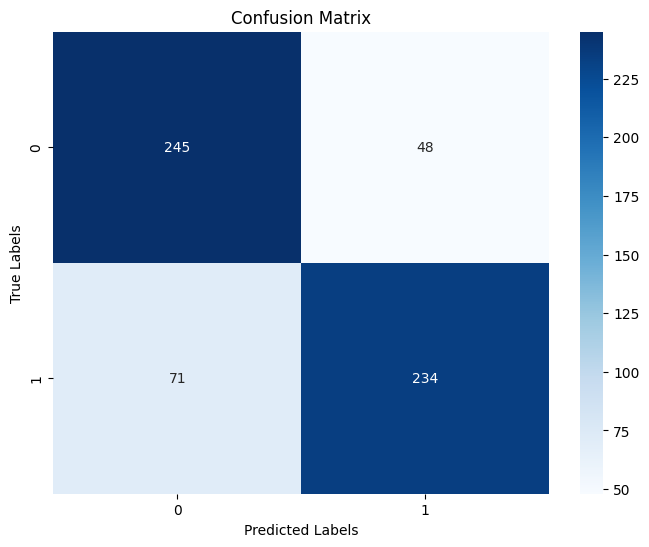

In [31]:
from sklearn.metrics import confusion_matrix

# Assuming 'test_df' contains the true labels for the test set
true_labels = test_df['enc_label'].tolist()  # Replace 'enc_label' with the actual column name for true labels

# Generate predictions
predictions = []
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Generating Test Predictions"):
        ids = batch['ids'].to(device)
        mask = batch['mask'].to(device)

        # Get model outputs
        outputs = model(ids, attention_mask=mask)
        _, predicted = torch.max(outputs.logits, dim=1)
        predictions.extend(predicted.cpu().numpy())

# Calculate the macro F1 score
macro_f1 = f1_score(true_labels, predictions, average='macro')

# Calculate the accuracy
test_accuracy = accuracy_score(true_labels, predictions)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)

# Calculate precision and recall
precision = precision_score(true_labels, predictions, average='macro')
recall = recall_score(true_labels, predictions, average='macro')

# Print the Macro F1 Score, Test Accuracy, and Confusion Matrix
print(f"Macro F1 Score: {macro_f1:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Plotting the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

**Hyperparameter Tuning**

In [32]:
# Set random seed for reproducibility
seed_value = 42
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)

# Define tokenizer for XLM-RoBERTa
model_name = 'xlm-roberta-base'  # Switching to XLM-RoBERTa
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Constants
MAX_LEN = 128
BATCH_SIZE = 16
NUM_CLASSES = 2  # Update based on your dataset
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Custom Dataset Class
class TamilDataset(Dataset):
    def __init__(self, texts, labels=None, tokenizer=None, max_len=None, is_labeled=False):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.is_labeled = is_labeled

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        input_ids = encoding['input_ids'].flatten()
        attention_mask = encoding['attention_mask'].flatten()

        if self.is_labeled:
            label = self.labels[item]
            return {
                'ids': input_ids,
                'mask': attention_mask,
                'targets': torch.tensor(label, dtype=torch.long)
            }
        else:
            return {
                'ids': input_ids,
                'mask': attention_mask
            }

# Prepare datasets
train_set = TamilDataset(train_df['cleanText'].tolist(), train_df['enc_label'].tolist(), tokenizer=tokenizer, max_len=MAX_LEN, is_labeled=True)
dev_set = TamilDataset(dev_df['cleanText'].tolist(), dev_df['enc_label'].tolist(), tokenizer=tokenizer, max_len=MAX_LEN, is_labeled=True)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
dev_loader = DataLoader(dev_set, batch_size=BATCH_SIZE, shuffle=False)

test_set = TamilDataset(test_df['cleanText'].tolist(), test_df['enc_label'].tolist(), tokenizer=tokenizer, max_len=MAX_LEN, is_labeled=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

# Define model
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=NUM_CLASSES
)
model.to(device)

# Define loss function (CrossEntropyLoss)
criterion = torch.nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5)

# Learning Rate Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.1)

# Mixed-Precision Training
scaler = torch.cuda.amp.GradScaler()

# Training loop
def train_model():
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    for batch in tqdm(train_loader, desc="Training Batches"):
        optimizer.zero_grad()

        input_ids = batch['ids'].to(device)
        attention_mask = batch['mask'].to(device)
        labels = batch['targets'].to(device)

        with torch.cuda.amp.autocast():  # Mixed-precision
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits, labels)  # Compute the loss here

        scaler.scale(loss).backward()  # Backpropagate gradients

        scaler.step(optimizer)  # Update weights
        scaler.update()  # Update the scaler

        total_loss += loss.item()

        preds = torch.argmax(outputs.logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    return total_loss / len(train_loader), accuracy

# Validation loop
def evaluate_model():
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(dev_loader, desc="Validation Batches"):
            input_ids = batch['ids'].to(device)
            attention_mask = batch['mask'].to(device)
            labels = batch['targets'].to(device)

            with torch.cuda.amp.autocast():  # Mixed-precision
                outputs = model(input_ids, attention_mask=attention_mask)
                loss = criterion(outputs.logits, labels)

            total_loss += loss.item()

            preds = torch.argmax(outputs.logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    return total_loss / len(dev_loader), accuracy, f1

# Training and evaluation loop
EPOCHS = 8
for epoch in range(EPOCHS):
    train_loss, train_accuracy = train_model()
    val_loss, val_accuracy, val_f1 = evaluate_model()

    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy:.4f}")
    print(f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_accuracy:.4f} | F1 Score: {val_f1:.4f}")

    # Learning rate scheduler
    scheduler.step(val_loss)


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validation Batches: 100%|██████████| 38/38 [00:01<00:00, 24.90it/s]


Epoch 1/8
Train Loss: 0.6960 | Train Accuracy: 0.5038
Validation Loss: 0.6876 | Validation Accuracy: 0.5753 | F1 Score: 0.5319


Validation Batches: 100%|██████████| 38/38 [00:01<00:00, 25.20it/s]


Epoch 2/8
Train Loss: 0.6664 | Train Accuracy: 0.6078
Validation Loss: 0.5980 | Validation Accuracy: 0.6572 | F1 Score: 0.6331


Validation Batches: 100%|██████████| 38/38 [00:01<00:00, 25.01it/s]


Epoch 3/8
Train Loss: 0.5896 | Train Accuracy: 0.7017
Validation Loss: 0.5490 | Validation Accuracy: 0.7475 | F1 Score: 0.7478


Validation Batches: 100%|██████████| 38/38 [00:01<00:00, 25.18it/s]


Epoch 4/8
Train Loss: 0.5367 | Train Accuracy: 0.7431
Validation Loss: 0.6180 | Validation Accuracy: 0.7207 | F1 Score: 0.7061


Validation Batches: 100%|██████████| 38/38 [00:01<00:00, 25.10it/s]


Epoch 5/8
Train Loss: 0.4762 | Train Accuracy: 0.7852
Validation Loss: 0.5272 | Validation Accuracy: 0.7726 | F1 Score: 0.7718


Validation Batches: 100%|██████████| 38/38 [00:01<00:00, 25.26it/s]


Epoch 6/8
Train Loss: 0.4172 | Train Accuracy: 0.8176
Validation Loss: 0.5160 | Validation Accuracy: 0.7876 | F1 Score: 0.7879


Validation Batches: 100%|██████████| 38/38 [00:01<00:00, 25.19it/s]


Epoch 7/8
Train Loss: 0.3689 | Train Accuracy: 0.8435
Validation Loss: 0.5760 | Validation Accuracy: 0.7726 | F1 Score: 0.7725


Validation Batches: 100%|██████████| 38/38 [00:01<00:00, 25.01it/s]

Epoch 8/8
Train Loss: 0.3227 | Train Accuracy: 0.8687
Validation Loss: 0.5260 | Validation Accuracy: 0.8077 | F1 Score: 0.8070


Generating Test Predictions: 100%|██████████| 38/38 [00:04<00:00,  8.31it/s]


Macro F1 Score: 0.7773
Test Accuracy: 0.7776
Precision: 0.7808
Recall: 0.7786


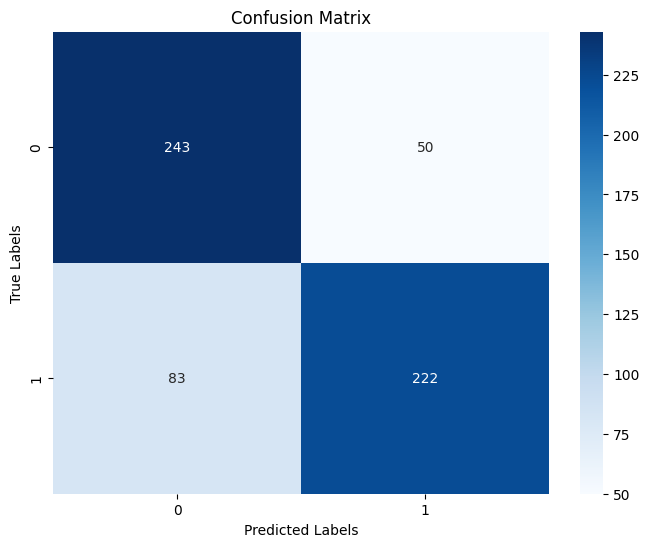

In [33]:
from sklearn.metrics import confusion_matrix

# Assuming 'test_df' contains the true labels for the test set
true_labels = test_df['enc_label'].tolist()  # Replace 'enc_label' with the actual column name for true labels

# Generate predictions
predictions = []
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Generating Test Predictions"):
        ids = batch['ids'].to(device)
        mask = batch['mask'].to(device)

        # Get model outputs
        outputs = model(ids, attention_mask=mask)
        _, predicted = torch.max(outputs.logits, dim=1)
        predictions.extend(predicted.cpu().numpy())

# Calculate the macro F1 score
macro_f1 = f1_score(true_labels, predictions, average='macro')

# Calculate the accuracy
test_accuracy = accuracy_score(true_labels, predictions)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)

# Calculate precision and recall
precision = precision_score(true_labels, predictions, average='macro')
recall = recall_score(true_labels, predictions, average='macro')

# Print the Macro F1 Score, Test Accuracy, and Confusion Matrix
print(f"Macro F1 Score: {macro_f1:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Plotting the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [152]:
# Store sample texts, true labels, and predictions
sample_texts = []  
all_preds = []
all_targets = []

# Iterate over the test set to collect predictions
with torch.no_grad():
    for batch_idx, batch in enumerate(test_loader):
        ids = batch['ids'].to(device)
        mask = batch['mask'].to(device)
        targets = batch['targets'].to(device)

        outputs = model(ids, attention_mask=mask)
        _, predicted = torch.max(outputs.logits, 1)

        # Store predictions and actual labels
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

        # Collect the 'cleanText' for the current batch from the test dataframe
        start_idx = batch_idx * BATCH_SIZE
        end_idx = start_idx + len(batch['ids'])
        sample_texts.extend(test_df['cleanText'].iloc[start_idx:end_idx].tolist())

# Randomly select some samples to display
num_samples = 5  # Number of examples to display
sample_indices = np.random.choice(len(all_targets), num_samples, replace=False)

# Prepare the sample data for display
sample_data = {
    "Text": [sample_texts[i] for i in sample_indices],
    "Actual Label and Predicted Label": [f"{all_targets[i]} -> {all_preds[i]}" for i in sample_indices]
}

# Create a DataFrame
sample_df = pd.DataFrame(sample_data)

# Display the DataFrame with the format "Actual Label -> Predicted Label"
print("\nSample Predictions:")
print(sample_df)


Sample Predictions:
                                                Text  \
0  சச்ச திவ்யா முன் டா மே உண்மையில் அந்தப் பரட்டை...   
1  உன்னோட ஆசைக்காக பெத்தவங்கள கஷ்ட படுத்தாத நீதான...   
2  பெரிய ஹீரோயின் கூட இப்பிடி ஸேல்ஃபிஏ ஏதுக்க மத்...   
3  உங்க பாலொவர்சை பார்க்கும் போது தெரியுது ஷகிலாவ...   
4  இப்படி ஒரு பெண் இருக்குறதுக்கு இல்லாம இருக்கலா...   

  Actual Label and Predicted Label  
0                           1 -> 0  
1                           1 -> 1  
2                           0 -> 0  
3                           1 -> 1  
4                           1 -> 1  


**Indic Sentence-BERT**

In [34]:
# Set random seed for reproducibility
seed_value = 42
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)

# Define tokenizer and model for Indic Sentence-BERT
model_name = 'l3cube-pune/indic-sentence-bert-nli'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)  # Set `num_labels` for binary classification
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Constants
MAX_LEN = 128
BATCH_SIZE = 32

# Custom Dataset Class
class TamilDataset(Dataset):
    def __init__(self, texts, labels=None, tokenizer=None, max_len=None, is_labeled=False):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.is_labeled = is_labeled

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        input_ids = encoding['input_ids'].flatten()
        attention_mask = encoding['attention_mask'].flatten()

        if self.is_labeled:
            label = self.labels[item]
            return {
                'ids': input_ids,
                'mask': attention_mask,
                'targets': torch.tensor(label, dtype=torch.long)
            }
        else:
            return {
                'ids': input_ids,
                'mask': attention_mask
            }

# Prepare datasets
train_set = TamilDataset(train_df['cleanText'].tolist(), train_df['enc_label'].tolist(), tokenizer=tokenizer, max_len=MAX_LEN, is_labeled=True)
dev_set = TamilDataset(dev_df['cleanText'].tolist(), dev_df['enc_label'].tolist(), tokenizer=tokenizer, max_len=MAX_LEN, is_labeled=True)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
dev_loader = DataLoader(dev_set, batch_size=BATCH_SIZE, shuffle=False)

test_set = TamilDataset(test_df['cleanText'].tolist(), test_df['enc_label'].tolist(), tokenizer=tokenizer, max_len=MAX_LEN, is_labeled=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

# Loss and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

# Mixed-precision training
scaler = torch.cuda.amp.GradScaler()

# Training loop
def train_model():
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    for batch in tqdm(train_loader, desc="Training Batches"):
        optimizer.zero_grad()

        input_ids = batch['ids'].to(device)
        attention_mask = batch['mask'].to(device)
        labels = batch['targets'].to(device)

        with torch.cuda.amp.autocast():
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()

        preds = torch.argmax(outputs.logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    return total_loss / len(train_loader), accuracy

# Validation loop
def evaluate_model():
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(dev_loader, desc="Validation Batches"):
            input_ids = batch['ids'].to(device)
            attention_mask = batch['mask'].to(device)
            labels = batch['targets'].to(device)

            with torch.cuda.amp.autocast():
                outputs = model(input_ids, attention_mask=attention_mask)
                loss = criterion(outputs.logits, labels)

            total_loss += loss.item()

            preds = torch.argmax(outputs.logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    return total_loss / len(dev_loader), accuracy, f1

# Training and evaluation loop
EPOCHS = 12
for epoch in range(EPOCHS):
    train_loss, train_accuracy = train_model()
    val_loss, val_accuracy, val_f1 = evaluate_model()

    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy:.4f}")
    print(f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_accuracy:.4f} | F1 Score: {val_f1:.4f}")


tokenizer_config.json:   0%|          | 0.00/577 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/3.16M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/6.41M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/668 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/950M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at l3cube-pune/indic-sentence-bert-nli and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validation Batches: 100%|██████████| 19/19 [00:01<00:00, 15.46it/s]


Epoch 1/12
Train Loss: 0.6860 | Train Accuracy: 0.6402
Validation Loss: 0.6658 | Validation Accuracy: 0.6839 | F1 Score: 0.6629


Validation Batches: 100%|██████████| 19/19 [00:01<00:00, 14.70it/s]


Epoch 2/12
Train Loss: 0.6150 | Train Accuracy: 0.7600
Validation Loss: 0.5654 | Validation Accuracy: 0.7642 | F1 Score: 0.7645


Validation Batches: 100%|██████████| 19/19 [00:01<00:00, 15.62it/s]


Epoch 3/12
Train Loss: 0.5138 | Train Accuracy: 0.8165
Validation Loss: 0.5199 | Validation Accuracy: 0.7676 | F1 Score: 0.7670


Validation Batches: 100%|██████████| 19/19 [00:01<00:00, 15.69it/s]


Epoch 4/12
Train Loss: 0.4267 | Train Accuracy: 0.8510
Validation Loss: 0.4895 | Validation Accuracy: 0.7826 | F1 Score: 0.7817


Validation Batches: 100%|██████████| 19/19 [00:01<00:00, 15.04it/s]


Epoch 5/12
Train Loss: 0.3502 | Train Accuracy: 0.8856
Validation Loss: 0.4735 | Validation Accuracy: 0.8027 | F1 Score: 0.8027


Validation Batches: 100%|██████████| 19/19 [00:01<00:00, 15.34it/s]


Epoch 6/12
Train Loss: 0.2947 | Train Accuracy: 0.9064
Validation Loss: 0.5124 | Validation Accuracy: 0.7876 | F1 Score: 0.7872


Validation Batches: 100%|██████████| 19/19 [00:01<00:00, 15.50it/s]


Epoch 7/12
Train Loss: 0.2548 | Train Accuracy: 0.9219
Validation Loss: 0.5091 | Validation Accuracy: 0.8027 | F1 Score: 0.8027


Validation Batches: 100%|██████████| 19/19 [00:01<00:00, 15.51it/s]


Epoch 8/12
Train Loss: 0.2097 | Train Accuracy: 0.9410
Validation Loss: 0.5190 | Validation Accuracy: 0.8194 | F1 Score: 0.8188


Validation Batches: 100%|██████████| 19/19 [00:01<00:00, 15.26it/s]


Epoch 9/12
Train Loss: 0.1804 | Train Accuracy: 0.9514
Validation Loss: 0.5690 | Validation Accuracy: 0.7843 | F1 Score: 0.7842


Validation Batches: 100%|██████████| 19/19 [00:01<00:00, 15.31it/s]


Epoch 10/12
Train Loss: 0.1654 | Train Accuracy: 0.9532
Validation Loss: 0.5501 | Validation Accuracy: 0.8094 | F1 Score: 0.8095


Validation Batches: 100%|██████████| 19/19 [00:01<00:00, 15.58it/s]


Epoch 11/12
Train Loss: 0.1401 | Train Accuracy: 0.9593
Validation Loss: 0.5789 | Validation Accuracy: 0.7960 | F1 Score: 0.7962


Validation Batches: 100%|██████████| 19/19 [00:01<00:00, 15.38it/s]

Epoch 12/12
Train Loss: 0.1131 | Train Accuracy: 0.9701
Validation Loss: 0.5865 | Validation Accuracy: 0.8027 | F1 Score: 0.8029


In [35]:
from sklearn.metrics import f1_score, accuracy_score

# Assuming 'test_df' contains the true labels for the test set
true_labels = test_df['enc_label'].tolist()  # Replace 'enc_label' with the actual column name for true labels

# Generate predictions
predictions = []
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Generating Test Predictions"):
        input_ids = batch['ids'].to(device)
        attention_mask = batch['mask'].to(device)

        # Get model outputs
        outputs = model(input_ids, attention_mask=attention_mask)
        _, predicted = torch.max(outputs.logits, dim=1)
        predictions.extend(predicted.cpu().numpy())

# Calculate the macro F1 score
macro_f1 = f1_score(true_labels, predictions, average='macro')

# Calculate the accuracy
test_accuracy = accuracy_score(true_labels, predictions)

# Calculate precision and recall
precision = precision_score(true_labels, predictions, average='macro')
recall = recall_score(true_labels, predictions, average='macro')

# Print the Macro F1 Score and Test Accuracy
print(f"Macro F1 Score: {macro_f1:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Generating Test Predictions: 100%|██████████| 19/19 [00:04<00:00,  4.30it/s]

Macro F1 Score: 0.7684
Test Accuracy: 0.7692
Precision: 0.7710
Recall: 0.7683


**DistilBERT-mc**

In [36]:
# Set random seed for reproducibility
seed_value = 42
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)

# Define tokenizer and model for distilbert-base-multilingual-cased
model_name = 'distilbert-base-multilingual-cased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)  # Set `num_labels` for binary classification
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Constants
MAX_LEN = 128
BATCH_SIZE = 32

# Custom Dataset Class
class TamilDataset(Dataset):
    def __init__(self, texts, labels=None, tokenizer=None, max_len=None, is_labeled=False):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.is_labeled = is_labeled

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        input_ids = encoding['input_ids'].flatten()
        attention_mask = encoding['attention_mask'].flatten()

        if self.is_labeled:
            label = self.labels[item]
            return {
                'ids': input_ids,
                'mask': attention_mask,
                'targets': torch.tensor(label, dtype=torch.long)
            }
        else:
            return {
                'ids': input_ids,
                'mask': attention_mask
            }

# Prepare datasets
train_set = TamilDataset(train_df['cleanText'].tolist(), train_df['enc_label'].tolist(), tokenizer=tokenizer, max_len=MAX_LEN, is_labeled=True)
dev_set = TamilDataset(dev_df['cleanText'].tolist(), dev_df['enc_label'].tolist(), tokenizer=tokenizer, max_len=MAX_LEN, is_labeled=True)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
dev_loader = DataLoader(dev_set, batch_size=BATCH_SIZE, shuffle=False)

test_set = TamilDataset(test_df['cleanText'].tolist(), test_df['enc_label'].tolist(), tokenizer=tokenizer, max_len=MAX_LEN, is_labeled=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

# Loss and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

# Mixed-precision training
scaler = torch.cuda.amp.GradScaler()

# Training loop
def train_model():
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    for batch in tqdm(train_loader, desc="Training Batches"):
        optimizer.zero_grad()

        input_ids = batch['ids'].to(device)
        attention_mask = batch['mask'].to(device)
        labels = batch['targets'].to(device)

        with torch.cuda.amp.autocast():
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()

        preds = torch.argmax(outputs.logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    return total_loss / len(train_loader), accuracy

# Validation loop
def evaluate_model():
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(dev_loader, desc="Validation Batches"):
            input_ids = batch['ids'].to(device)
            attention_mask = batch['mask'].to(device)
            labels = batch['targets'].to(device)

            with torch.cuda.amp.autocast():
                outputs = model(input_ids, attention_mask=attention_mask)
                loss = criterion(outputs.logits, labels)

            total_loss += loss.item()

            preds = torch.argmax(outputs.logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    return total_loss / len(dev_loader), accuracy, f1

# Training and evaluation loop
EPOCHS = 12
for epoch in range(EPOCHS):
    train_loss, train_accuracy = train_model()
    val_loss, val_accuracy, val_f1 = evaluate_model()

    print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy:.4f}")
    print(f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_accuracy:.4f} | F1 Score: {val_f1:.4f}")


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validation Batches: 100%|██████████| 19/19 [00:00<00:00, 25.48it/s]


Train Loss: 0.6790 | Train Accuracy: 0.5603
Validation Loss: 0.6099 | Validation Accuracy: 0.6555 | F1 Score: 0.6556


Validation Batches: 100%|██████████| 19/19 [00:00<00:00, 24.95it/s]


Train Loss: 0.5612 | Train Accuracy: 0.7107
Validation Loss: 0.5168 | Validation Accuracy: 0.7559 | F1 Score: 0.7561


Validation Batches: 100%|██████████| 19/19 [00:00<00:00, 24.30it/s]


Train Loss: 0.5059 | Train Accuracy: 0.7503
Validation Loss: 0.5284 | Validation Accuracy: 0.7375 | F1 Score: 0.7340


Validation Batches: 100%|██████████| 19/19 [00:00<00:00, 25.09it/s]


Train Loss: 0.4430 | Train Accuracy: 0.7978
Validation Loss: 0.4906 | Validation Accuracy: 0.7575 | F1 Score: 0.7578


Validation Batches: 100%|██████████| 19/19 [00:00<00:00, 25.17it/s]


Train Loss: 0.3845 | Train Accuracy: 0.8356
Validation Loss: 0.5364 | Validation Accuracy: 0.7542 | F1 Score: 0.7513


Validation Batches: 100%|██████████| 19/19 [00:00<00:00, 25.46it/s]


Train Loss: 0.3361 | Train Accuracy: 0.8611
Validation Loss: 0.5196 | Validation Accuracy: 0.7575 | F1 Score: 0.7577


Validation Batches: 100%|██████████| 19/19 [00:00<00:00, 25.19it/s]


Train Loss: 0.2782 | Train Accuracy: 0.8852
Validation Loss: 0.6017 | Validation Accuracy: 0.7525 | F1 Score: 0.7526


Validation Batches: 100%|██████████| 19/19 [00:00<00:00, 25.31it/s]


Train Loss: 0.2216 | Train Accuracy: 0.9104
Validation Loss: 0.6728 | Validation Accuracy: 0.7391 | F1 Score: 0.7350


Validation Batches: 100%|██████████| 19/19 [00:00<00:00, 24.91it/s]


Train Loss: 0.1972 | Train Accuracy: 0.9205
Validation Loss: 0.6785 | Validation Accuracy: 0.7341 | F1 Score: 0.7341


Validation Batches: 100%|██████████| 19/19 [00:00<00:00, 25.02it/s]


Train Loss: 0.1297 | Train Accuracy: 0.9550
Validation Loss: 0.7890 | Validation Accuracy: 0.7441 | F1 Score: 0.7444


Validation Batches: 100%|██████████| 19/19 [00:00<00:00, 24.90it/s]


Train Loss: 0.1021 | Train Accuracy: 0.9644
Validation Loss: 0.8548 | Validation Accuracy: 0.7542 | F1 Score: 0.7539


Validation Batches: 100%|██████████| 19/19 [00:00<00:00, 25.12it/s]

Train Loss: 0.0845 | Train Accuracy: 0.9673
Validation Loss: 0.9205 | Validation Accuracy: 0.7408 | F1 Score: 0.7411


In [37]:
from sklearn.metrics import f1_score, accuracy_score

# Assuming 'test_df' contains the true labels for the test set
true_labels = test_df['enc_label'].tolist()  # Replace 'enc_label' with the actual column name for true labels

# Generate predictions
predictions = []
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Generating Test Predictions"):
        input_ids = batch['ids'].to(device)
        attention_mask = batch['mask'].to(device)

        # Get model outputs
        outputs = model(input_ids, attention_mask=attention_mask)
        _, predicted = torch.max(outputs.logits, dim=1)
        predictions.extend(predicted.cpu().numpy())

# Calculate the Macro F1 Score
macro_f1 = f1_score(true_labels, predictions, average='macro')

# Calculate the Test Accuracy
test_accuracy = accuracy_score(true_labels, predictions)

# Calculate precision and recall
precision = precision_score(true_labels, predictions, average='macro')
recall = recall_score(true_labels, predictions, average='macro')


# Print the results
print(f"Macro F1 Score: {macro_f1:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Generating Test Predictions: 100%|██████████| 19/19 [00:02<00:00,  8.51it/s]

Macro F1 Score: 0.7485
Test Accuracy: 0.7492
Precision: 0.7500
Recall: 0.7485


**DeOffXLMR-Tamil**

In [38]:
# Set random seed for reproducibility
seed_value = 42
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)

# Define tokenizer and model name
model_name = 'Hate-speech-CNERG/deoffxlmr-mono-tamil'
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Constants
MAX_LEN = 128
BATCH_SIZE = 32
NUM_CLASSES = 2  # Update based on your dataset
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Custom Dataset Class
class TamilDataset(Dataset):
    def __init__(self, texts, labels=None, tokenizer=None, max_len=None, is_labeled=False):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.is_labeled = is_labeled

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        input_ids = encoding['input_ids'].flatten()
        attention_mask = encoding['attention_mask'].flatten()

        if self.is_labeled:
            label = self.labels[item]
            return {
                'ids': input_ids,
                'mask': attention_mask,
                'targets': torch.tensor(label, dtype=torch.long)
            }
        else:
            return {
                'ids': input_ids,
                'mask': attention_mask
            }

# Prepare datasets (replace train_df and dev_df with your actual data)
train_set = TamilDataset(train_df['cleanText'].tolist(), train_df['enc_label'].tolist(), tokenizer=tokenizer, max_len=MAX_LEN, is_labeled=True)
dev_set = TamilDataset(dev_df['cleanText'].tolist(), dev_df['enc_label'].tolist(), tokenizer=tokenizer, max_len=MAX_LEN, is_labeled=True)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
dev_loader = DataLoader(dev_set, batch_size=BATCH_SIZE, shuffle=False)

test_set = TamilDataset(test_df['cleanText'].tolist(), test_df['enc_label'].tolist(), tokenizer=tokenizer, max_len=MAX_LEN, is_labeled=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

# Define model
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=NUM_CLASSES ,ignore_mismatched_sizes=True
)

# Resize the classification head to match NUM_CLASSES
model.classifier.out_proj = torch.nn.Linear(model.config.hidden_size, NUM_CLASSES)

model.to(device)

# Define loss function (CrossEntropyLoss)
criterion = torch.nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

# Learning Rate Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.1)

# Mixed-Precision Training
scaler = torch.cuda.amp.GradScaler()

# Training loop
def train_model():
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    for batch in tqdm(train_loader, desc="Training Batches"):
        optimizer.zero_grad()

        input_ids = batch['ids'].to(device)
        attention_mask = batch['mask'].to(device)
        labels = batch['targets'].to(device)

        with torch.cuda.amp.autocast():  # Mixed-precision
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits, labels)

        scaler.scale(loss).backward()  # Backpropagate gradients
        scaler.step(optimizer)  # Update weights
        scaler.update()  # Update the scaler

        total_loss += loss.item()

        preds = torch.argmax(outputs.logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    return total_loss / len(train_loader), accuracy

# Validation loop
def evaluate_model():
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(dev_loader, desc="Validation Batches"):
            input_ids = batch['ids'].to(device)
            attention_mask = batch['mask'].to(device)
            labels = batch['targets'].to(device)

            with torch.cuda.amp.autocast():  # Mixed-precision
                outputs = model(input_ids, attention_mask=attention_mask)
                loss = criterion(outputs.logits, labels)

            total_loss += loss.item()

            preds = torch.argmax(outputs.logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    return total_loss / len(dev_loader), accuracy, f1

# Training and evaluation loop
EPOCHS = 12
for epoch in range(EPOCHS):
    train_loss, train_accuracy = train_model()
    val_loss, val_accuracy, val_f1 = evaluate_model()

    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy:.4f}")
    print(f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_accuracy:.4f} | F1 Score: {val_f1:.4f}")

    # Learning rate scheduler
    scheduler.step(val_loss)


tokenizer_config.json:   0%|          | 0.00/211 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at Hate-speech-CNERG/deoffxlmr-mono-tamil and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([6, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([6]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validation Batches: 100%|██████████| 19/19 [00:01<00:00, 14.32it/s]


Epoch 1/12
Train Loss: 0.6288 | Train Accuracy: 0.6387
Validation Loss: 0.5536 | Validation Accuracy: 0.7358 | F1 Score: 0.7314


Validation Batches: 100%|██████████| 19/19 [00:01<00:00, 13.43it/s]


Epoch 2/12
Train Loss: 0.4935 | Train Accuracy: 0.7686
Validation Loss: 0.5054 | Validation Accuracy: 0.7559 | F1 Score: 0.7560


Validation Batches: 100%|██████████| 19/19 [00:01<00:00, 12.88it/s]


Epoch 3/12
Train Loss: 0.3892 | Train Accuracy: 0.8381
Validation Loss: 0.5108 | Validation Accuracy: 0.7759 | F1 Score: 0.7759


Validation Batches: 100%|██████████| 19/19 [00:01<00:00, 13.60it/s]


Epoch 4/12
Train Loss: 0.3167 | Train Accuracy: 0.8723
Validation Loss: 0.5238 | Validation Accuracy: 0.7692 | F1 Score: 0.7694


Validation Batches: 100%|██████████| 19/19 [00:01<00:00, 13.47it/s]


Epoch 5/12
Train Loss: 0.2256 | Train Accuracy: 0.9162
Validation Loss: 0.6295 | Validation Accuracy: 0.7676 | F1 Score: 0.7651


Validation Batches: 100%|██████████| 19/19 [00:01<00:00, 13.22it/s]


Epoch 6/12
Train Loss: 0.1509 | Train Accuracy: 0.9539
Validation Loss: 0.6488 | Validation Accuracy: 0.7709 | F1 Score: 0.7709


Validation Batches: 100%|██████████| 19/19 [00:01<00:00, 13.48it/s]


Epoch 7/12
Train Loss: 0.1405 | Train Accuracy: 0.9547
Validation Loss: 0.6599 | Validation Accuracy: 0.7793 | F1 Score: 0.7791


Validation Batches: 100%|██████████| 19/19 [00:01<00:00, 13.50it/s]


Epoch 8/12
Train Loss: 0.1256 | Train Accuracy: 0.9590
Validation Loss: 0.6828 | Validation Accuracy: 0.7776 | F1 Score: 0.7777


Validation Batches: 100%|██████████| 19/19 [00:01<00:00, 13.39it/s]


Epoch 9/12
Train Loss: 0.1164 | Train Accuracy: 0.9601
Validation Loss: 0.6835 | Validation Accuracy: 0.7759 | F1 Score: 0.7759


Validation Batches: 100%|██████████| 19/19 [00:01<00:00, 13.37it/s]


Epoch 10/12
Train Loss: 0.1132 | Train Accuracy: 0.9647
Validation Loss: 0.6862 | Validation Accuracy: 0.7776 | F1 Score: 0.7776


Validation Batches: 100%|██████████| 19/19 [00:01<00:00, 13.40it/s]


Epoch 11/12
Train Loss: 0.1104 | Train Accuracy: 0.9651
Validation Loss: 0.6883 | Validation Accuracy: 0.7759 | F1 Score: 0.7759


Validation Batches: 100%|██████████| 19/19 [00:01<00:00, 13.51it/s]

Epoch 12/12
Train Loss: 0.1165 | Train Accuracy: 0.9622
Validation Loss: 0.6885 | Validation Accuracy: 0.7759 | F1 Score: 0.7759


In [39]:
# Assuming 'test_df' contains the true labels for the test set
true_labels = test_df['enc_label'].tolist()  # Replace 'enc_label' with the actual column name for true labels

# Generate predictions
predictions = []
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Generating Test Predictions"):
        input_ids = batch['ids'].to(device)
        attention_mask = batch['mask'].to(device)

        # Get model outputs
        outputs = model(input_ids, attention_mask=attention_mask)
        _, predicted = torch.max(outputs.logits, dim=1)
        predictions.extend(predicted.cpu().numpy())

# Calculate the Macro F1 Score
macro_f1 = f1_score(true_labels, predictions, average='macro')

# Calculate the Test Accuracy
test_accuracy = accuracy_score(true_labels, predictions)

# Calculate precision and recall
precision = precision_score(true_labels, predictions, average='macro')
recall = recall_score(true_labels, predictions, average='macro')


# Print the results
print(f"Macro F1 Score: {macro_f1:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Generating Test Predictions: 100%|██████████| 19/19 [00:04<00:00,  4.35it/s]

Macro F1 Score: 0.7675
Test Accuracy: 0.7676
Precision: 0.7675
Recall: 0.7676


**Tamil BERT**

In [40]:
# Set random seed for reproducibility
seed_value = 42
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)

# Define tokenizer for Tamil BERT
model_name = 'ai4bharat/indic-bert'  # Tamil-specific pre-trained model
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Constants
MAX_LEN = 128
BATCH_SIZE = 32
NUM_CLASSES = 2  # Update based on your dataset (e.g., positive/negative sentiment)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Custom Dataset Class
class TamilDataset(Dataset):
    def __init__(self, texts, labels=None, tokenizer=None, max_len=None, is_labeled=False):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.is_labeled = is_labeled

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        input_ids = encoding['input_ids'].flatten()
        attention_mask = encoding['attention_mask'].flatten()

        if self.is_labeled:
            label = self.labels[item]
            return {
                'ids': input_ids,
                'mask': attention_mask,
                'targets': torch.tensor(label, dtype=torch.long)
            }
        else:
            return {
                'ids': input_ids,
                'mask': attention_mask
            }

# Prepare datasets
train_set = TamilDataset(train_df['cleanText'].tolist(), train_df['enc_label'].tolist(), tokenizer=tokenizer, max_len=MAX_LEN, is_labeled=True)
dev_set = TamilDataset(dev_df['cleanText'].tolist(), dev_df['enc_label'].tolist(), tokenizer=tokenizer, max_len=MAX_LEN, is_labeled=True)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
dev_loader = DataLoader(dev_set, batch_size=BATCH_SIZE, shuffle=False)

test_set = TamilDataset(test_df['cleanText'].tolist(), test_df['enc_label'].tolist(), tokenizer=tokenizer, max_len=MAX_LEN, is_labeled=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

# Define model
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=NUM_CLASSES
)
model.to(device)

# Define loss function (CrossEntropyLoss)
criterion = torch.nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-6)

# Learning Rate Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.1)

# Mixed-Precision Training
scaler = torch.cuda.amp.GradScaler()

# Training loop
def train_model():
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    for batch in tqdm(train_loader, desc="Training Batches"):
        optimizer.zero_grad()

        input_ids = batch['ids'].to(device)
        attention_mask = batch['mask'].to(device)
        labels = batch['targets'].to(device)

        with torch.cuda.amp.autocast():  # Mixed-precision
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits, labels)  # Compute the loss here

        scaler.scale(loss).backward()  # Backpropagate gradients

        scaler.step(optimizer)  # Update weights
        scaler.update()  # Update the scaler

        total_loss += loss.item()

        preds = torch.argmax(outputs.logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    return total_loss / len(train_loader), accuracy

# Validation loop
def evaluate_model():
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(dev_loader, desc="Validation Batches"):
            input_ids = batch['ids'].to(device)
            attention_mask = batch['mask'].to(device)
            labels = batch['targets'].to(device)

            with torch.cuda.amp.autocast():  # Mixed-precision
                outputs = model(input_ids, attention_mask=attention_mask)
                loss = criterion(outputs.logits, labels)

            total_loss += loss.item()

            preds = torch.argmax(outputs.logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    return total_loss / len(dev_loader), accuracy, f1

# Training and evaluation loop
EPOCHS = 12
for epoch in range(EPOCHS):
    train_loss, train_accuracy = train_model()
    val_loss, val_accuracy, val_f1 = evaluate_model()

    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy:.4f}")
    print(f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_accuracy:.4f} | F1 Score: {val_f1:.4f}")

    # Learning rate scheduler
    scheduler.step(val_loss)


config.json:   0%|          | 0.00/507 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/5.65M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/135M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validation Batches: 100%|██████████| 19/19 [00:01<00:00, 13.09it/s]


Epoch 1/12
Train Loss: 0.6930 | Train Accuracy: 0.5121
Validation Loss: 0.6925 | Validation Accuracy: 0.5351 | F1 Score: 0.3731


Validation Batches: 100%|██████████| 19/19 [00:01<00:00, 12.65it/s]


Epoch 2/12
Train Loss: 0.6926 | Train Accuracy: 0.5257
Validation Loss: 0.6924 | Validation Accuracy: 0.5468 | F1 Score: 0.4194


Validation Batches: 100%|██████████| 19/19 [00:01<00:00, 13.42it/s]


Epoch 3/12
Train Loss: 0.6917 | Train Accuracy: 0.5621
Validation Loss: 0.6914 | Validation Accuracy: 0.5803 | F1 Score: 0.5756


Validation Batches: 100%|██████████| 19/19 [00:01<00:00, 13.62it/s]


Epoch 4/12
Train Loss: 0.6887 | Train Accuracy: 0.5952
Validation Loss: 0.6890 | Validation Accuracy: 0.5719 | F1 Score: 0.5693


Validation Batches: 100%|██████████| 19/19 [00:01<00:00, 13.30it/s]


Epoch 5/12
Train Loss: 0.6800 | Train Accuracy: 0.6438
Validation Loss: 0.6819 | Validation Accuracy: 0.6020 | F1 Score: 0.6008


Validation Batches: 100%|██████████| 19/19 [00:01<00:00, 13.25it/s]


Epoch 6/12
Train Loss: 0.6661 | Train Accuracy: 0.6808
Validation Loss: 0.6757 | Validation Accuracy: 0.6037 | F1 Score: 0.6032


Validation Batches: 100%|██████████| 19/19 [00:01<00:00, 13.30it/s]


Epoch 7/12
Train Loss: 0.6510 | Train Accuracy: 0.6920
Validation Loss: 0.6669 | Validation Accuracy: 0.6438 | F1 Score: 0.6377


Validation Batches: 100%|██████████| 19/19 [00:01<00:00, 13.37it/s]


Epoch 8/12
Train Loss: 0.6302 | Train Accuracy: 0.7154
Validation Loss: 0.6609 | Validation Accuracy: 0.6555 | F1 Score: 0.6541


Validation Batches: 100%|██████████| 19/19 [00:01<00:00, 13.49it/s]


Epoch 9/12
Train Loss: 0.6098 | Train Accuracy: 0.7409
Validation Loss: 0.6549 | Validation Accuracy: 0.6555 | F1 Score: 0.6473


Validation Batches: 100%|██████████| 19/19 [00:01<00:00, 13.38it/s]


Epoch 10/12
Train Loss: 0.5914 | Train Accuracy: 0.7517
Validation Loss: 0.6828 | Validation Accuracy: 0.6421 | F1 Score: 0.6415


Validation Batches: 100%|██████████| 19/19 [00:01<00:00, 13.32it/s]


Epoch 11/12
Train Loss: 0.5682 | Train Accuracy: 0.7744
Validation Loss: 0.6589 | Validation Accuracy: 0.6589 | F1 Score: 0.6568


Validation Batches: 100%|██████████| 19/19 [00:01<00:00, 13.21it/s]

Epoch 12/12
Train Loss: 0.5531 | Train Accuracy: 0.7845
Validation Loss: 0.6819 | Validation Accuracy: 0.6555 | F1 Score: 0.6559


In [41]:
# Assuming 'test_df' contains the true labels for the test set
true_labels = test_df['enc_label'].tolist()  # Replace 'enc_label' with the actual column name for true labels

# Generate predictions
predictions = []
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Generating Test Predictions"):
        input_ids = batch['ids'].to(device)
        attention_mask = batch['mask'].to(device)

        # Get model outputs
        outputs = model(input_ids, attention_mask=attention_mask)
        _, predicted = torch.max(outputs.logits, dim=1)
        predictions.extend(predicted.cpu().numpy())

# Calculate the Macro F1 Score
macro_f1 = f1_score(true_labels, predictions, average='macro')

# Calculate the Test Accuracy
test_accuracy = accuracy_score(true_labels, predictions)

# Calculate precision and recall
precision = precision_score(true_labels, predictions, average='macro')
recall = recall_score(true_labels, predictions, average='macro')


# Print the results
print(f"Macro F1 Score: {macro_f1:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Generating Test Predictions: 100%|██████████| 19/19 [00:04<00:00,  4.13it/s]

Macro F1 Score: 0.6789
Test Accuracy: 0.6806
Precision: 0.6821
Recall: 0.6794


**MuRIL**

In [42]:
# Set random seed for reproducibility
seed_value = 42
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)

# Define tokenizer and model name
model_name = 'google/muril-base-cased'  # Changed model
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Constants
MAX_LEN = 128
BATCH_SIZE = 32
NUM_CLASSES = 2  # Update based on your dataset
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Custom Dataset Class
class TamilDataset(Dataset):
    def __init__(self, texts, labels=None, tokenizer=None, max_len=None, is_labeled=False):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.is_labeled = is_labeled

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        input_ids = encoding['input_ids'].flatten()
        attention_mask = encoding['attention_mask'].flatten()

        if self.is_labeled:
            label = self.labels[item]
            return {
                'ids': input_ids,
                'mask': attention_mask,
                'targets': torch.tensor(label, dtype=torch.long)
            }
        else:
            return {
                'ids': input_ids,
                'mask': attention_mask
            }

# Prepare datasets (replace train_df and dev_df with your actual data)
train_set = TamilDataset(train_df['cleanText'].tolist(), train_df['enc_label'].tolist(), tokenizer=tokenizer, max_len=MAX_LEN, is_labeled=True)
dev_set = TamilDataset(dev_df['cleanText'].tolist(), dev_df['enc_label'].tolist(), tokenizer=tokenizer, max_len=MAX_LEN, is_labeled=True)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
dev_loader = DataLoader(dev_set, batch_size=BATCH_SIZE, shuffle=False)

test_set = TamilDataset(test_df['cleanText'].tolist(), test_df['enc_label'].tolist(), tokenizer=tokenizer, max_len=MAX_LEN, is_labeled=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

# Define model
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=NUM_CLASSES, ignore_mismatched_sizes=True
)

# Resize the classification head to match NUM_CLASSES
model.classifier.out_proj = torch.nn.Linear(model.config.hidden_size, NUM_CLASSES)

model.to(device)

# Define loss function (CrossEntropyLoss)
criterion = torch.nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

# Learning Rate Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.1)

# Mixed-Precision Training
scaler = torch.cuda.amp.GradScaler()

# Training loop
def train_model():
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    for batch in tqdm(train_loader, desc="Training Batches"):
        optimizer.zero_grad()

        input_ids = batch['ids'].to(device)
        attention_mask = batch['mask'].to(device)
        labels = batch['targets'].to(device)

        with torch.cuda.amp.autocast():  # Mixed-precision
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits, labels)

        scaler.scale(loss).backward()  # Backpropagate gradients
        scaler.step(optimizer)  # Update weights
        scaler.update()  # Update the scaler

        total_loss += loss.item()

        preds = torch.argmax(outputs.logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    return total_loss / len(train_loader), accuracy

# Validation loop
def evaluate_model():
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(dev_loader, desc="Validation Batches"):
            input_ids = batch['ids'].to(device)
            attention_mask = batch['mask'].to(device)
            labels = batch['targets'].to(device)

            with torch.cuda.amp.autocast():  # Mixed-precision
                outputs = model(input_ids, attention_mask=attention_mask)
                loss = criterion(outputs.logits, labels)

            total_loss += loss.item()

            preds = torch.argmax(outputs.logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    return total_loss / len(dev_loader), accuracy, f1

# Training and evaluation loop
EPOCHS = 12
for epoch in range(EPOCHS):
    train_loss, train_accuracy = train_model()
    val_loss, val_accuracy, val_f1 = evaluate_model()

    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy:.4f}")
    print(f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_accuracy:.4f} | F1 Score: {val_f1:.4f}")

    # Learning rate scheduler
    scheduler.step(val_loss)


tokenizer_config.json:   0%|          | 0.00/206 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/411 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/3.16M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/113 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/953M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/muril-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validation Batches: 100%|██████████| 19/19 [00:01<00:00, 15.79it/s]


Epoch 1/12
Train Loss: 0.6921 | Train Accuracy: 0.5480
Validation Loss: 0.6856 | Validation Accuracy: 0.6873 | F1 Score: 0.6823


Validation Batches: 100%|██████████| 19/19 [00:01<00:00, 15.19it/s]


Epoch 2/12
Train Loss: 0.6481 | Train Accuracy: 0.7344
Validation Loss: 0.6152 | Validation Accuracy: 0.7191 | F1 Score: 0.7168


Validation Batches: 100%|██████████| 19/19 [00:01<00:00, 15.93it/s]


Epoch 3/12
Train Loss: 0.5633 | Train Accuracy: 0.7895
Validation Loss: 0.5619 | Validation Accuracy: 0.7492 | F1 Score: 0.7450


Validation Batches: 100%|██████████| 19/19 [00:01<00:00, 16.10it/s]


Epoch 4/12
Train Loss: 0.4875 | Train Accuracy: 0.8215
Validation Loss: 0.5186 | Validation Accuracy: 0.7625 | F1 Score: 0.7626


Validation Batches: 100%|██████████| 19/19 [00:01<00:00, 15.77it/s]


Epoch 5/12
Train Loss: 0.4086 | Train Accuracy: 0.8600
Validation Loss: 0.5012 | Validation Accuracy: 0.7776 | F1 Score: 0.7779


Validation Batches: 100%|██████████| 19/19 [00:01<00:00, 15.59it/s]


Epoch 6/12
Train Loss: 0.3342 | Train Accuracy: 0.8888
Validation Loss: 0.5111 | Validation Accuracy: 0.7793 | F1 Score: 0.7792


Validation Batches: 100%|██████████| 19/19 [00:01<00:00, 16.17it/s]


Epoch 7/12
Train Loss: 0.3005 | Train Accuracy: 0.8956
Validation Loss: 0.5515 | Validation Accuracy: 0.7692 | F1 Score: 0.7679


Validation Batches: 100%|██████████| 19/19 [00:01<00:00, 16.03it/s]


Epoch 8/12
Train Loss: 0.2335 | Train Accuracy: 0.9295
Validation Loss: 0.6014 | Validation Accuracy: 0.7609 | F1 Score: 0.7601


Validation Batches: 100%|██████████| 19/19 [00:01<00:00, 15.87it/s]


Epoch 9/12
Train Loss: 0.1940 | Train Accuracy: 0.9485
Validation Loss: 0.5977 | Validation Accuracy: 0.7592 | F1 Score: 0.7595


Validation Batches: 100%|██████████| 19/19 [00:01<00:00, 15.94it/s]


Epoch 10/12
Train Loss: 0.1786 | Train Accuracy: 0.9547
Validation Loss: 0.6074 | Validation Accuracy: 0.7625 | F1 Score: 0.7628


Validation Batches: 100%|██████████| 19/19 [00:01<00:00, 15.85it/s]


Epoch 11/12
Train Loss: 0.1729 | Train Accuracy: 0.9565
Validation Loss: 0.6188 | Validation Accuracy: 0.7609 | F1 Score: 0.7612


Validation Batches: 100%|██████████| 19/19 [00:01<00:00, 15.85it/s]

Epoch 12/12
Train Loss: 0.1640 | Train Accuracy: 0.9608
Validation Loss: 0.6200 | Validation Accuracy: 0.7592 | F1 Score: 0.7595


In [43]:
# Assuming 'test_df' contains the true labels for the test set
true_labels = test_df['enc_label'].tolist()  # Replace 'enc_label' with the actual column name for true labels

# Generate predictions
predictions = []
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Generating Test Predictions"):
        ids = batch['ids'].to(device)
        mask = batch['mask'].to(device)

        # Get model outputs
        outputs = model(ids, attention_mask=mask)
        _, predicted = torch.max(outputs.logits, dim=1)
        predictions.extend(predicted.cpu().numpy())

# Calculate the macro F1 score
macro_f1 = f1_score(true_labels, predictions, average='macro')

# Calculate the test accuracy
test_accuracy = accuracy_score(true_labels, predictions)

# Calculate precision and recall
precision = precision_score(true_labels, predictions, average='macro')
recall = recall_score(true_labels, predictions, average='macro')


# Print the results
print(f"Macro F1 Score: {macro_f1:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Generating Test Predictions: 100%|██████████| 19/19 [00:04<00:00,  4.31it/s]

Macro F1 Score: 0.7723
Test Accuracy: 0.7726
Precision: 0.7727
Recall: 0.7722
